In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


class   fake  real
split             
dev    10295  2548
eval   26412  6334
train  10660  2525


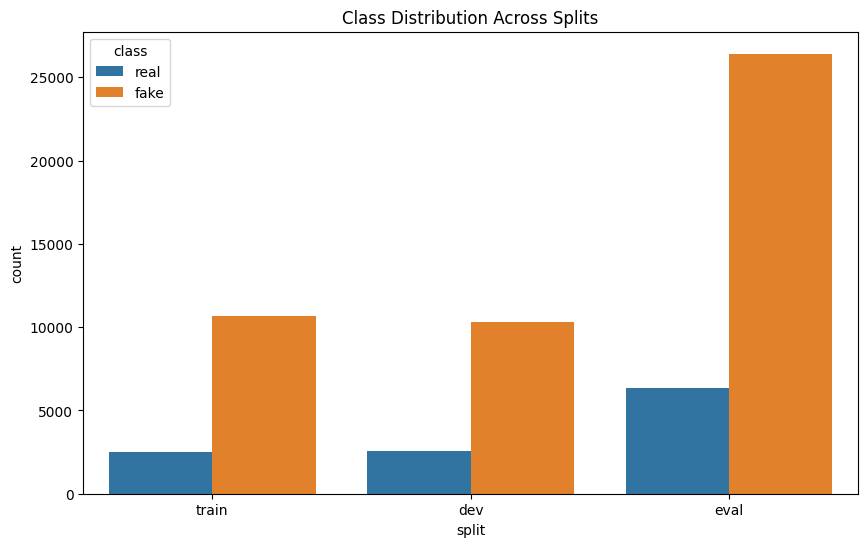

In [8]:
# Configure the dataset root and which split to use (change these to switch datasets)
# Set dataset_root to the folder that contains `train`, `dev`, and `eval` subfolders
dataset_root = r"d:\\ML\\archive"  # <- update if your data is elsewhere
# selected_split can be 'train', 'dev', or 'eval'
selected_split = 'train'

def get_split_class_path(root, split, cls):
    return os.path.join(root, split, cls)

def analyze_dataset(base_path):
    splits = ['train', 'dev', 'eval']
    classes = ['real', 'fake']
    data = []
    for split in splits:
        for cls in classes:
            path = os.path.join(base_path, split, cls)
            if os.path.exists(path):
                count = len([f for f in os.listdir(path) if f.lower().endswith('.wav')])
            else:
                count = 0
            data.append({'split': split, 'class': cls, 'count': count})
    df = pd.DataFrame(data)
    return df

dataset_stats = analyze_dataset(dataset_root)
print(dataset_stats.pivot(index='split', columns='class', values='count'))

plt.figure(figsize=(10, 6))
sns.barplot(x='split', y='count', hue='class', data=dataset_stats)
plt.title('Class Distribution Across Splits')
plt.show()

Sample Rate: 16000 Hz
Duration: 4.13 seconds
Audio Signal Shape: (66109,)
Zero-Crossing Rate: 0.0526


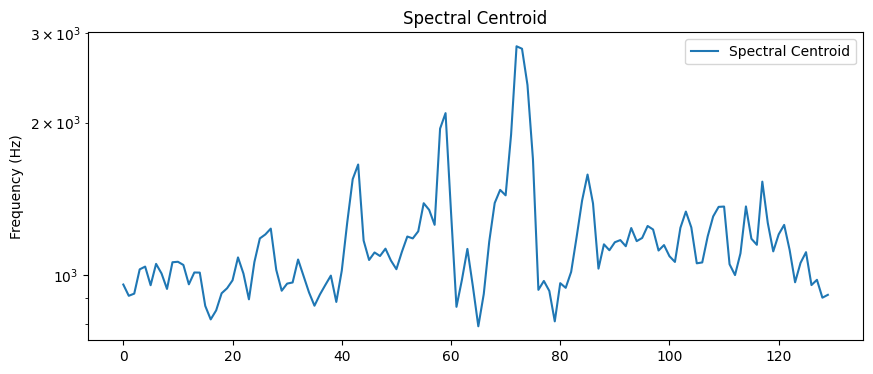

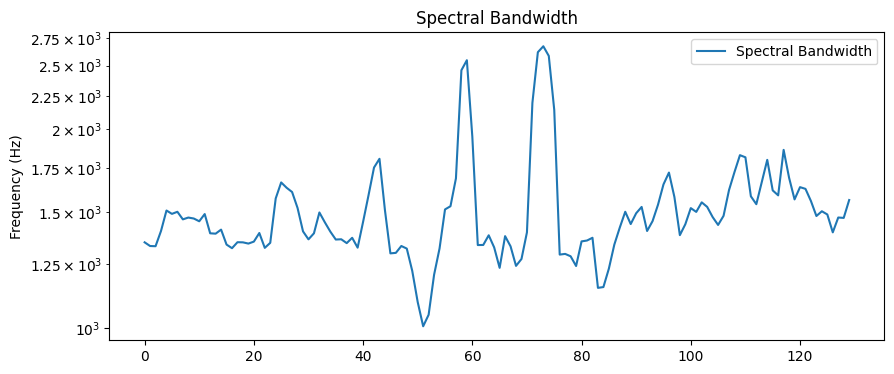

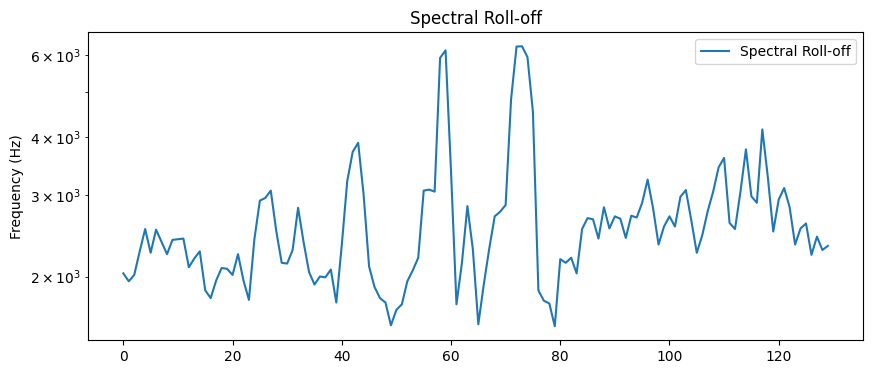

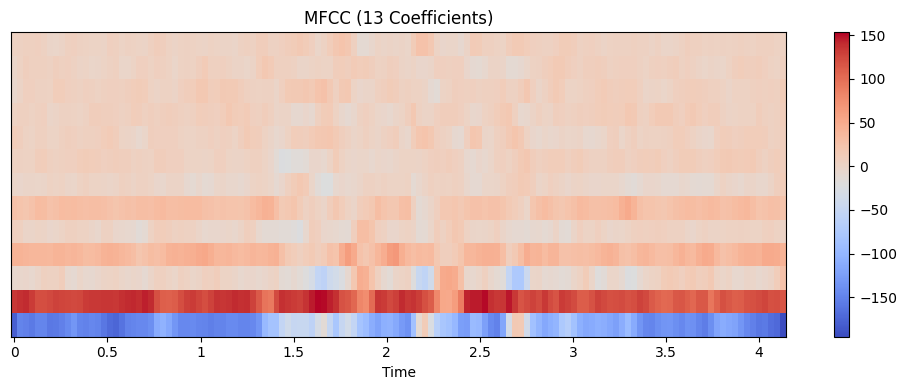

In [9]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Load an example audio file from the selected split (will pick the first available real file)
example_dir = get_split_class_path(dataset_root, selected_split, 'real')
example_filename = None
if os.path.exists(example_dir):
    wavs = [f for f in os.listdir(example_dir) if f.lower().endswith('.wav')]
    if len(wavs) > 0:
        example_filename = os.path.join(example_dir, wavs[0])
if example_filename is None:
    raise FileNotFoundError(f"No WAV file found in {example_dir}. Update `dataset_root` or `selected_split`.")
y, sr = librosa.load(example_filename, sr=None)

# Get duration of the audio
duration = librosa.get_duration(y=y, sr=sr)
print(f"Sample Rate: {sr} Hz")
print(f"Duration: {duration:.2f} seconds")
print(f"Audio Signal Shape: {y.shape}")

#Zero-Crossing Rate
zero_crossings = librosa.zero_crossings(y, pad=False)
zcr_rate = np.sum(zero_crossings) / len(y)
print(f"Zero-Crossing Rate: {zcr_rate:.4f}")

#Spectral Centroid
spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
plt.figure(figsize=(10, 4))
plt.semilogy(spectral_centroids.T, label='Spectral Centroid')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Centroid')
plt.legend(loc='upper right')
plt.show()

#Spectral Bandwidth
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
plt.figure(figsize=(10, 4))
plt.semilogy(spectral_bandwidth.T, label='Spectral Bandwidth')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Bandwidth')
plt.legend(loc='upper right')
plt.show()

#Spectral Roll-off
spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
plt.figure(figsize=(10, 4))
plt.semilogy(spectral_rolloff.T, label='Spectral Roll-off')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Roll-off')
plt.legend(loc='upper right')
plt.show()

#MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar()
plt.title('MFCC (13 Coefficients)')
plt.tight_layout()
plt.show()


In [10]:
def extract_mfcc_features(filename, n_mfcc=13):
    y, sr = librosa.load(filename, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)
    feature_vector = np.concatenate((mfcc_mean, mfcc_std))
    return feature_vector


In [ ]:
import os

def load_features_from_directory(directory_path, n_mfcc=13):
    features = []
    file_names = []  # Optional: to keep track of filenames
    if not os.path.exists(directory_path):
        print(f"Warning: directory does not exist: {directory_path}")
        return np.array(features), file_names
    for file in os.listdir(directory_path):
        if file.lower().endswith('.wav'):
            file_path = os.path.join(directory_path, file)
            try:
                feature_vector = extract_mfcc_features(file_path, n_mfcc=n_mfcc)
                features.append(feature_vector)
                file_names.append(file)
            except Exception as e:
                print(f"Failed to extract from {file_path}: {e}")
    return np.array(features), file_names

# Build paths using dataset_root and selected_split
fake_dir = get_split_class_path(dataset_root, selected_split, 'fake')
real_dir = get_split_class_path(dataset_root, selected_split, 'real')

# Load features for each class
print(f"Loading fake files from: {fake_dir}")
X_fake, fake_files = load_features_from_directory(fake_dir, n_mfcc=13)
print(f"Loaded {len(fake_files)} fake files.")
print(f"Loading real files from: {real_dir}")`11111gbv`
X_real, real_files = load_features_from_directory(real_dir, n_mfcc=13)
print(f"Loaded {len(real_files)} real files.")

print("Fake features shape:", X_fake.shape)  # Expected: (number_of_fake_files, 26)
print("Real features shape:", X_real.shape)  # Expected: (number_of_real_files, 26)


Loading fake files from: d:\\ML\\archive\train\fake
Loaded 10660 fake files.
Loading real files from: d:\\ML\\archive\train\real
Loaded 2525 real files.
Fake features shape: (10660, 26)
Real features shape: (2525, 26)


In [12]:
# Create labels: 0 for fake, 1 for real
y_fake = np.zeros(X_fake.shape[0], dtype=int)
y_real = np.ones(X_real.shape[0], dtype=int)

# Stack features and labels
X_train = np.vstack((X_fake, X_real))
y_train = np.concatenate((y_fake, y_real))

print("Combined training set shape:", X_train.shape)
print("Training labels distribution:", np.unique(y_train, return_counts=True))


Combined training set shape: (13185, 26)
Training labels distribution: (array([0, 1]), array([10660,  2525]))


In [13]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

print("Original distribution:", Counter(y_train))
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print("Resampled distribution:", Counter(y_resampled))


Original distribution: Counter({np.int64(0): 10660, np.int64(1): 2525})
Resampled distribution: Counter({np.int64(0): 10660, np.int64(1): 10660})


## Handling Class Imbalance - Multiple Strategies

You have several options to handle the imbalanced dataset (fake:real ≈ 4:1):

### 1. **Oversampling** (Currently Used)
- ✅ **RandomOverSampler**: Duplicates minority class samples
- ✅ **SMOTE**: Creates synthetic minority samples (better generalization)
- ✅ **ADASYN**: Adaptive synthetic sampling

### 2. **Undersampling**
- ⚠️ **RandomUnderSampler**: Removes majority class samples (may lose information)
- ⚠️ **TomekLinks**: Removes borderline majority samples
- ⚠️ **ClusterCentroids**: Replaces majority cluster with centroids

### 3. **Combined Sampling**
- ✅ **SMOTEENN**: SMOTE + Edited Nearest Neighbors
- ✅ **SMOTETomek**: SMOTE + Tomek Links removal

### 4. **Class Weights** (No Sampling)
- ✅ **class_weight='balanced'**: Let the model handle imbalance automatically
- ✅ Best when you want to keep original data distribution

### 5. **Ensemble Methods**
- ✅ **BalancedRandomForest**: Built-in balancing
- ✅ **EasyEnsemble**: Creates balanced subsets

**Recommendation**: Try SMOTE (better than simple oversampling) or class_weight='balanced' (simplest)

## 📊 Quick Summary: Your Class Imbalance Problem

**Current Situation:**
- Train: **10,660 fake** vs **2,525 real** (ratio 4.2:1)
- Dev: **10,295 fake** vs **2,548 real** (ratio 4.0:1)  
- Eval: **26,412 fake** vs **6,334 real** (ratio 4.2:1)

**Problem:** Models trained on imbalanced data tend to:
- Predict the majority class (fake) most of the time
- Ignore the minority class (real) → poor recall for real samples
- Give misleadingly high accuracy (e.g., 80% accuracy by just predicting "fake" always!)

---

## 🎯 Solutions: Which Strategy to Use?

### **✅ RECOMMENDED: SMOTE** (Synthetic Minority Over-sampling Technique)
- **What it does:** Creates synthetic "real" samples by interpolating between existing ones
- **Pros:** Better generalization than simple duplication, no information loss
- **Cons:** Can create noisy samples in some cases
- **Use when:** You want to balance classes without losing data

### **✅ GOOD ALTERNATIVE: Class Weights**
- **What it does:** Tells the model to penalize mistakes on minority class more
- **Pros:** Simplest method, no data manipulation, faster training
- **Cons:** May not work as well as resampling for very imbalanced data
- **Use when:** You want the fastest solution or have limited computational resources

### **⚠️ USE WITH CAUTION: Undersampling**
- **What it does:** Reduces majority class (fake) to match minority class
- **Pros:** Balanced dataset, faster training
- **Cons:** **Throws away 8,135 fake samples!** (loses potentially useful information)
- **Use when:** You have millions of samples and can afford to lose some

---

## 💡 My Recommendations for Your Data:

1. **First try: SMOTE** → Run the cell below with `RESAMPLING_STRATEGY = 'smote'`
2. **Second try: Class Weight** → Change to `RESAMPLING_STRATEGY = 'class_weight'`
3. **Compare results** → Use the comparison cell to see which works best
4. **Evaluate on dev/eval** → Change `selected_split = 'dev'` to test on unseen data

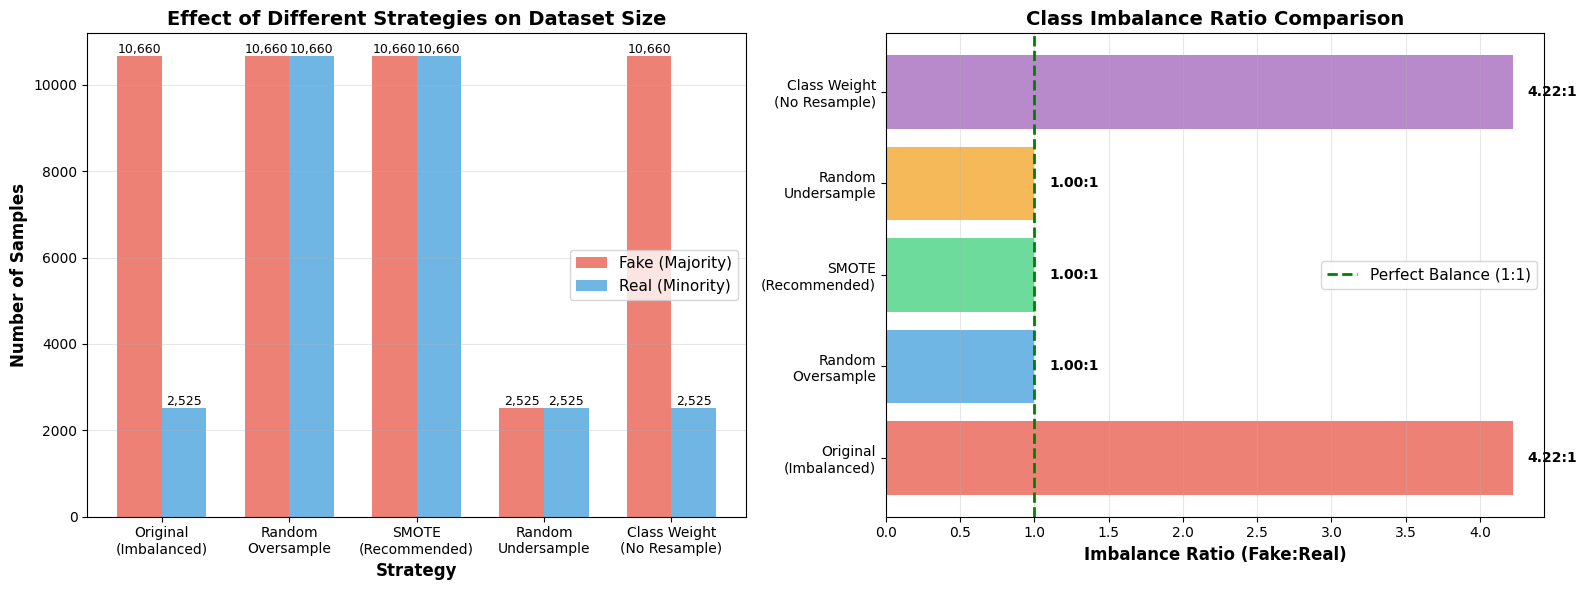


📊 STRATEGY COMPARISON SUMMARY
Strategy                  Total Samples   Ratio           Notes
----------------------------------------------------------------------
Original (Imbalanced)     13,185          4.2:1           ⚠️ High imbalance
Random Oversample         21,320          1:1             ✓ Duplicates real
SMOTE (Recommended)       21,320          1:1             ✅ Synthetic real
Random Undersample        5,050           1:1             ⚠️ Loses 8,135 fakes
Class Weight              13,185          4.2:1           ✓ Model handles it


In [14]:
# Visualize the impact of different resampling strategies
import matplotlib.pyplot as plt
import numpy as np

# Your current data (from the dataset analysis)
original_fake = 10660
original_real = 2525

strategies_data = {
    'Original\n(Imbalanced)': {'fake': original_fake, 'real': original_real, 'color': '#e74c3c'},
    'Random\nOversample': {'fake': original_fake, 'real': original_fake, 'color': '#3498db'},
    'SMOTE\n(Recommended)': {'fake': original_fake, 'real': original_fake, 'color': '#2ecc71'},
    'Random\nUndersample': {'fake': original_real, 'real': original_real, 'color': '#f39c12'},
    'Class Weight\n(No Resample)': {'fake': original_fake, 'real': original_real, 'color': '#9b59b6'},
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Sample counts
strategies = list(strategies_data.keys())
fake_counts = [strategies_data[s]['fake'] for s in strategies]
real_counts = [strategies_data[s]['real'] for s in strategies]

x = np.arange(len(strategies))
width = 0.35

bars1 = ax1.bar(x - width/2, fake_counts, width, label='Fake (Majority)', color='#e74c3c', alpha=0.7)
bars2 = ax1.bar(x + width/2, real_counts, width, label='Real (Minority)', color='#3498db', alpha=0.7)

ax1.set_xlabel('Strategy', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax1.set_title('Effect of Different Strategies on Dataset Size', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(strategies, fontsize=10)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=9)

# Plot 2: Imbalance ratio
ratios = []
labels = []
colors = []
for s in strategies:
    fake = strategies_data[s]['fake']
    real = strategies_data[s]['real']
    ratio = fake / real
    ratios.append(ratio)
    labels.append(s)
    colors.append(strategies_data[s]['color'])

bars = ax2.barh(labels, ratios, color=colors, alpha=0.7)
ax2.axvline(x=1, color='green', linestyle='--', linewidth=2, label='Perfect Balance (1:1)')
ax2.set_xlabel('Imbalance Ratio (Fake:Real)', fontsize=12, fontweight='bold')
ax2.set_title('Class Imbalance Ratio Comparison', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, ratio) in enumerate(zip(bars, ratios)):
    ax2.text(ratio + 0.1, i, f'{ratio:.2f}:1', 
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("📊 STRATEGY COMPARISON SUMMARY")
print("="*70)
print(f"{'Strategy':<25} {'Total Samples':<15} {'Ratio':<15} {'Notes'}")
print("-"*70)
print(f"{'Original (Imbalanced)':<25} {original_fake + original_real:<15,} {'4.2:1':<15} ⚠️ High imbalance")
print(f"{'Random Oversample':<25} {original_fake * 2:<15,} {'1:1':<15} ✓ Duplicates real")
print(f"{'SMOTE (Recommended)':<25} {original_fake * 2:<15,} {'1:1':<15} ✅ Synthetic real")
print(f"{'Random Undersample':<25} {original_real * 2:<15,} {'1:1':<15} ⚠️ Loses 8,135 fakes")
print(f"{'Class Weight':<25} {original_fake + original_real:<15,} {'4.2:1':<15} ✓ Model handles it")
print("="*70)

## 🚀 QUICK START GUIDE: How to Use These Strategies

### Step 1: Choose Your Strategy
Scroll down to the cell with `RESAMPLING_STRATEGY = 'smote'` and change it to one of:
- `'smote'` ← **Recommended first choice**
- `'class_weight'` ← **Fast alternative**
- `'random_oversample'` ← Simple duplication
- `'adasyn'` ← Adaptive synthetic sampling
- `'random_undersample'` ← Reduce majority class (loses data!)
- `'smote_tomek'` ← SMOTE + noise removal
- `'none'` ← Keep original imbalanced data

### Step 2: Run the Training Cells
After setting your strategy, run these cells in order:
1. The strategy selector cell (creates `X_balanced` and `y_balanced`)
2. The training cell (trains model and shows results)

### Step 3: Compare Results
Look at the classification report, especially:
- **F1-Score for "Real"** (minority class) - should be high!
- **Recall for "Real"** - are we catching real samples?
- **Precision for "Real"** - are we correctly identifying real?

### Step 4: Test on Dev/Eval Sets
Once you find a good strategy:
1. Change `selected_split = 'dev'` at the top
2. Rerun from feature extraction onwards
3. Check if performance holds on unseen data!

---

## 📝 Example: Trying SMOTE

```python
# In the strategy selector cell:
RESAMPLING_STRATEGY = 'smote'  # ← Set this

# Run the cells, check results
# If F1-Real is good → Great!
# If F1-Real is poor → Try 'class_weight' or 'smote_tomek'
```

---

## ⚡ Pro Tips

1. **Don't oversample before splitting!** Always split first, then oversample only the training set
2. **Test on original dev/eval** - Don't oversample your test sets!
3. **Watch for overfitting** - If train accuracy is 100% but test is 60%, you're overfitting
4. **Try ensemble methods** - XGBoost often handles imbalance well with `scale_pos_weight`

In [15]:
# ============================================
# STRATEGY SELECTOR: Choose your resampling strategy
# ============================================
# Options: 'none', 'random_oversample', 'smote', 'adasyn', 'random_undersample', 
#          'smote_tomek', 'smote_enn', 'class_weight'
RESAMPLING_STRATEGY = 'smote'  # <- Change this to try different strategies

from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

print(f"Original distribution: {Counter(y_train)}")
print(f"Imbalance ratio: {max(Counter(y_train).values()) / min(Counter(y_train).values()):.2f}:1")

if RESAMPLING_STRATEGY == 'none':
    print("\n✅ Strategy: No resampling (using original data)")
    X_balanced = X_train
    y_balanced = y_train
    
elif RESAMPLING_STRATEGY == 'random_oversample':
    print("\n✅ Strategy: Random Oversampling (duplicate minority class)")
    ros = RandomOverSampler(random_state=42)
    X_balanced, y_balanced = ros.fit_resample(X_train, y_train)
    
elif RESAMPLING_STRATEGY == 'smote':
    print("\n✅ Strategy: SMOTE (Synthetic Minority Over-sampling)")
    print("   Creates synthetic samples based on nearest neighbors")
    smote = SMOTE(random_state=42, k_neighbors=5)
    X_balanced, y_balanced = smote.fit_resample(X_train, y_train)
    
elif RESAMPLING_STRATEGY == 'adasyn':
    print("\n✅ Strategy: ADASYN (Adaptive Synthetic Sampling)")
    print("   Focuses on harder-to-learn minority samples")
    adasyn = ADASYN(random_state=42, n_neighbors=5)
    X_balanced, y_balanced = adasyn.fit_resample(X_train, y_train)
    
elif RESAMPLING_STRATEGY == 'random_undersample':
    print("\n⚠️  Strategy: Random Undersampling (reduce majority class)")
    print("   WARNING: This will discard majority class data!")
    rus = RandomUnderSampler(random_state=42)
    X_balanced, y_balanced = rus.fit_resample(X_train, y_train)
    
elif RESAMPLING_STRATEGY == 'smote_tomek':
    print("\n✅ Strategy: SMOTETomek (SMOTE + remove noisy samples)")
    print("   Best of both: oversample minority, clean borderline samples")
    smt = SMOTETomek(random_state=42)
    X_balanced, y_balanced = smt.fit_resample(X_train, y_train)
    
elif RESAMPLING_STRATEGY == 'smote_enn':
    print("\n✅ Strategy: SMOTEENN (SMOTE + Edited Nearest Neighbors)")
    print("   Oversample minority, then clean misclassified samples")
    smenn = SMOTEENN(random_state=42)
    X_balanced, y_balanced = smenn.fit_resample(X_train, y_train)
    
elif RESAMPLING_STRATEGY == 'class_weight':
    print("\n✅ Strategy: Class Weight (let the model handle it)")
    print("   No resampling - use class_weight='balanced' in model")
    X_balanced = X_train
    y_balanced = y_train
    
else:
    raise ValueError(f"Unknown strategy: {RESAMPLING_STRATEGY}")

print(f"\nBalanced distribution: {Counter(y_balanced)}")
print(f"Final dataset size: {len(y_balanced)} samples")
print(f"Shape: X={X_balanced.shape}, y={y_balanced.shape}")

Original distribution: Counter({np.int64(0): 10660, np.int64(1): 2525})
Imbalance ratio: 4.22:1

✅ Strategy: SMOTE (Synthetic Minority Over-sampling)
   Creates synthetic samples based on nearest neighbors

Balanced distribution: Counter({np.int64(0): 10660, np.int64(1): 10660})
Final dataset size: 21320 samples
Shape: X=(21320, 26), y=(21320,)



Strategy: SMOTE

Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      2132
        Real       0.99      0.99      0.99      2132

    accuracy                           0.99      4264
   macro avg       0.99      0.99      0.99      4264
weighted avg       0.99      0.99      0.99      4264



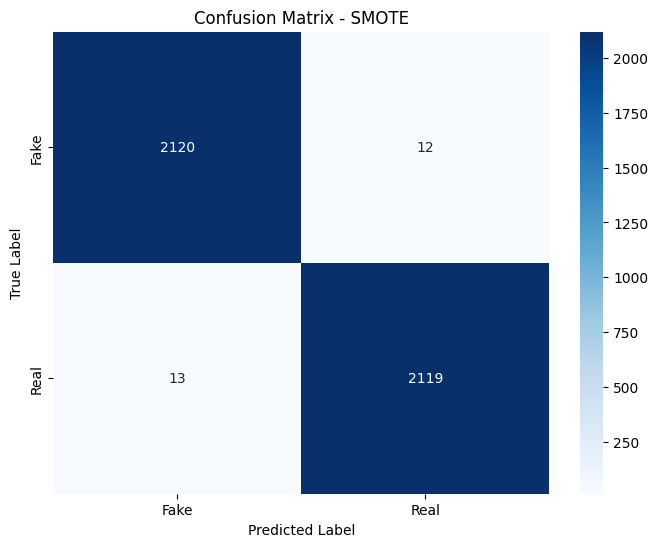


✅ Model trained successfully with smote strategy!


In [16]:
# ============================================
# Option 1: Train with RESAMPLED data
# ============================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Split the balanced dataset
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val_split)

# Train model
if RESAMPLING_STRATEGY == 'class_weight':
    # Use class weights instead of resampling
    clf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
else:
    clf = RandomForestClassifier(random_state=42, n_estimators=100)

clf.fit(X_train_scaled, y_train_split)
y_pred = clf.predict(X_val_scaled)

print(f"\n{'='*60}")
print(f"Strategy: {RESAMPLING_STRATEGY.upper()}")
print(f"{'='*60}")
print("\nClassification Report:")
print(classification_report(y_val_split, y_pred, target_names=['Fake', 'Real']))

# Confusion Matrix
cm = confusion_matrix(y_val_split, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title(f'Confusion Matrix - {RESAMPLING_STRATEGY.upper()}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\n✅ Model trained successfully with {RESAMPLING_STRATEGY} strategy!")

Comparing all resampling strategies... This may take a few minutes.

Testing: None (Original)... ✓ (F1-Macro: 0.955)
Testing: Random Oversample... ✓ (F1-Macro: 0.996)
Testing: SMOTE... ✓ (F1-Macro: 0.994)
Testing: ADASYN... ✓ (F1-Macro: 0.995)
Testing: Random Undersample... ✓ (F1-Macro: 0.980)
Testing: SMOTE-Tomek... ✓ (F1-Macro: 0.994)
Testing: Class Weight... ✓ (F1-Macro: 0.958)

COMPARISON RESULTS (sorted by F1-Macro score)
          Strategy  Accuracy  F1-Fake  F1-Real  F1-Macro  Train Size
 Random Oversample  0.995779 0.995785 0.995773  0.995779       17056
            ADASYN  0.995323 0.995299 0.995347  0.995323       17101
             SMOTE  0.994137 0.994141 0.994133  0.994137       17056
       SMOTE-Tomek  0.994137 0.994141 0.994133  0.994137       17056
Random Undersample  0.980198 0.980315 0.980080  0.980197        4040
      Class Weight  0.974972 0.984743 0.930380  0.957562       10548
   None (Original)  0.973455 0.983826 0.926004  0.954915       10548

💡 Recommendation

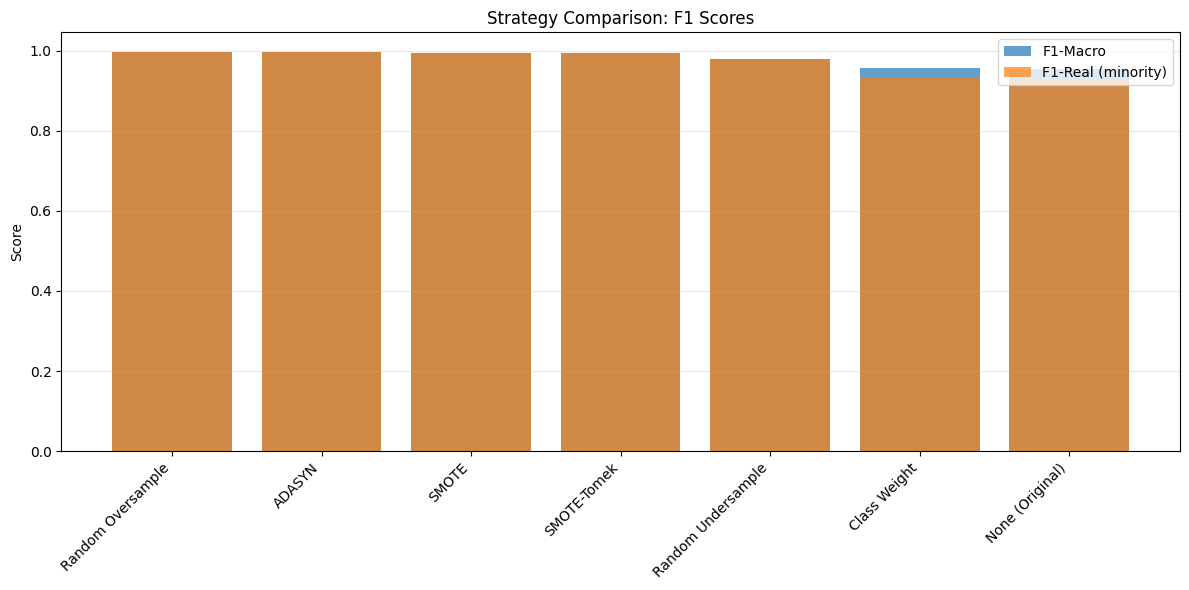

In [17]:
# ============================================
# BONUS: Compare ALL strategies at once
# ============================================
# This will take a few minutes but shows you which strategy works best

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score
import pandas as pd

strategies = {
    'None (Original)': ('none', None),
    'Random Oversample': ('oversample', RandomOverSampler(random_state=42)),
    'SMOTE': ('oversample', SMOTE(random_state=42, k_neighbors=5)),
    'ADASYN': ('oversample', ADASYN(random_state=42, n_neighbors=5)),
    'Random Undersample': ('undersample', RandomUnderSampler(random_state=42)),
    'SMOTE-Tomek': ('combine', SMOTETomek(random_state=42)),
    'Class Weight': ('weight', None)
}

results = []

print("Comparing all resampling strategies... This may take a few minutes.\n")

for strategy_name, (strategy_type, sampler) in strategies.items():
    try:
        print(f"Testing: {strategy_name}...", end=' ')
        
        # Apply resampling
        if strategy_type in ['oversample', 'undersample', 'combine']:
            X_temp, y_temp = sampler.fit_resample(X_train, y_train)
        else:
            X_temp, y_temp = X_train, y_train
        
        # Split and scale
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
        )
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_val_scaled = scaler.transform(X_val)
        
        # Train model
        if strategy_type == 'weight':
            clf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=50)
        else:
            clf = RandomForestClassifier(random_state=42, n_estimators=50)
        
        clf.fit(X_tr_scaled, y_tr)
        y_pred = clf.predict(X_val_scaled)
        
        # Evaluate
        acc = accuracy_score(y_val, y_pred)
        f1_fake = f1_score(y_val, y_pred, pos_label=0)
        f1_real = f1_score(y_val, y_pred, pos_label=1)
        f1_macro = f1_score(y_val, y_pred, average='macro')
        
        results.append({
            'Strategy': strategy_name,
            'Accuracy': acc,
            'F1-Fake': f1_fake,
            'F1-Real': f1_real,
            'F1-Macro': f1_macro,
            'Train Size': len(y_tr)
        })
        print(f"✓ (F1-Macro: {f1_macro:.3f})")
        
    except Exception as e:
        print(f"✗ Error: {str(e)}")
        continue

# Display results
results_df = pd.DataFrame(results).sort_values('F1-Macro', ascending=False)
print("\n" + "="*80)
print("COMPARISON RESULTS (sorted by F1-Macro score)")
print("="*80)
print(results_df.to_string(index=False))
print("\n💡 Recommendation: Use the strategy with the highest F1-Macro score")
print("   (especially if F1-Real is good, since 'Real' is your minority class)")

# Visualize comparison
plt.figure(figsize=(12, 6))
x_pos = range(len(results_df))
plt.bar(x_pos, results_df['F1-Macro'], alpha=0.7, label='F1-Macro')
plt.bar(x_pos, results_df['F1-Real'], alpha=0.7, label='F1-Real (minority)')
plt.xticks(x_pos, results_df['Strategy'], rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Strategy Comparison: F1 Scores')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
import pandas as pd

# Convert the features array into a DataFrame.
# Each row corresponds to one audio sample, and each column to a feature.
df_features = pd.DataFrame(X_train)

# Add theese labels as a new column
df_features['label'] = y_train

df_features.head()


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,label
0,-191.971497,118.298965,-28.662428,30.930485,0.734652,16.357052,0.512241,-4.494189,2.503700,-1.973033,...,22.915527,11.850456,11.763000,12.161544,10.317286,11.465570,10.472372,8.263680,6.253170,0
1,-217.288391,116.164505,15.024509,32.020199,16.623932,13.545458,-4.093700,0.018938,5.533595,8.699161,...,15.104014,13.951838,16.004261,11.728854,8.969705,7.588423,8.688404,8.756394,8.870028,0
2,-124.386627,123.388359,-18.295412,27.288525,8.977374,4.045929,-6.140698,-1.535464,-0.619506,2.353480,...,14.905897,10.124841,8.980715,7.104796,10.051600,6.117742,5.892004,6.342057,5.387593,0
3,-288.276459,119.512337,-6.566257,27.623133,5.877469,22.937799,-0.531199,2.179357,10.072868,10.011670,...,18.353388,8.387858,10.349126,14.883124,9.890210,8.259058,13.353674,9.775668,6.900864,0
4,-191.904083,136.176865,-24.540594,46.122086,10.140543,17.592983,7.181233,-11.822988,-1.799789,-0.630411,...,15.247070,19.836809,11.704630,10.222929,9.860342,10.280889,8.926976,7.838987,8.589583,0


What the Output Represents
Rows as Audio Samples:

Each row in the DataFrame represents one audio sample from your training dataset.

For example, row index 0 contains the feature information extracted from one audio file.

Columns 0 to 25:

These columns are your numerical features derived from the MFCC extraction process.

Since you set n_mfcc=13 and then computed two sets of statistics (mean and standard deviation) for each coefficient, you get 13 means and 13 standard deviations, making a total of 26 features per sample.

Columns 0–12: Represent the mean values of the 13 MFCC coefficients.

Columns 13–25: Represent the standard deviation (std) values of the 13 MFCC coefficients.

These features capture the spectral properties of the audio, providing a summary of the audio's frequency content and how it varies over time.

Label Column:

The final column, labeled label, contains the class labels.

In your case, a value of 0 means the audio sample is fake, and a value of 1 means it is real.

For instance, in the first row (index 0), the label is 0, indicating that this sample is from the fake class.

In [19]:
df_features.describe()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,label
count,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,...,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000
mean,-178.503571,120.317703,-3.112728,33.258209,2.525808,13.125817,-2.675782,-2.510688,2.578252,2.001035,...,15.150306,12.654090,10.629827,11.084830,9.535083,8.735169,8.061884,7.255114,6.924621,0.191505
std,56.569401,14.388311,13.865318,10.246736,8.536918,6.638049,6.094556,7.361274,6.219081,5.307193,...,5.037691,3.489625,3.076354,3.360745,2.560929,2.450857,2.031804,1.747890,1.804716,0.393501
min,-357.377747,62.816509,-54.238586,-11.283857,-35.123081,-15.522937,-32.175106,-29.255346,-22.486982,-21.369722,...,3.054486,3.270075,3.338605,3.455408,3.778903,2.992867,2.741304,2.698283,3.109181,0.000000
25%,-221.734726,111.372749,-11.115543,27.459166,-2.639140,8.919781,-6.673660,-5.464611,-0.088006,0.071939,...,11.350598,10.011785,8.272556,8.493075,7.493866,6.895406,6.494034,5.926713,5.563932,0.000000
50%,-178.558167,119.750427,-2.317568,33.670113,2.842486,13.101919,-2.048185,-0.894302,3.360826,3.028747,...,14.338881,12.326382,10.219996,10.602116,9.131670,8.412820,7.820954,7.020230,6.651354,0.000000
75%,-139.605804,129.012100,5.886300,40.174397,8.595044,17.839628,1.475842,2.330239,6.529912,5.330945,...,18.181896,14.909614,12.708825,13.279476,11.336356,10.195064,9.394934,8.379929,8.020983,0.000000
max,-2.584084,189.839157,40.581547,69.485664,27.461651,32.175930,15.024821,21.649548,19.292276,19.842207,...,40.564564,30.207773,23.594370,25.545240,19.869490,22.065228,19.354834,16.236158,16.708685,1.000000


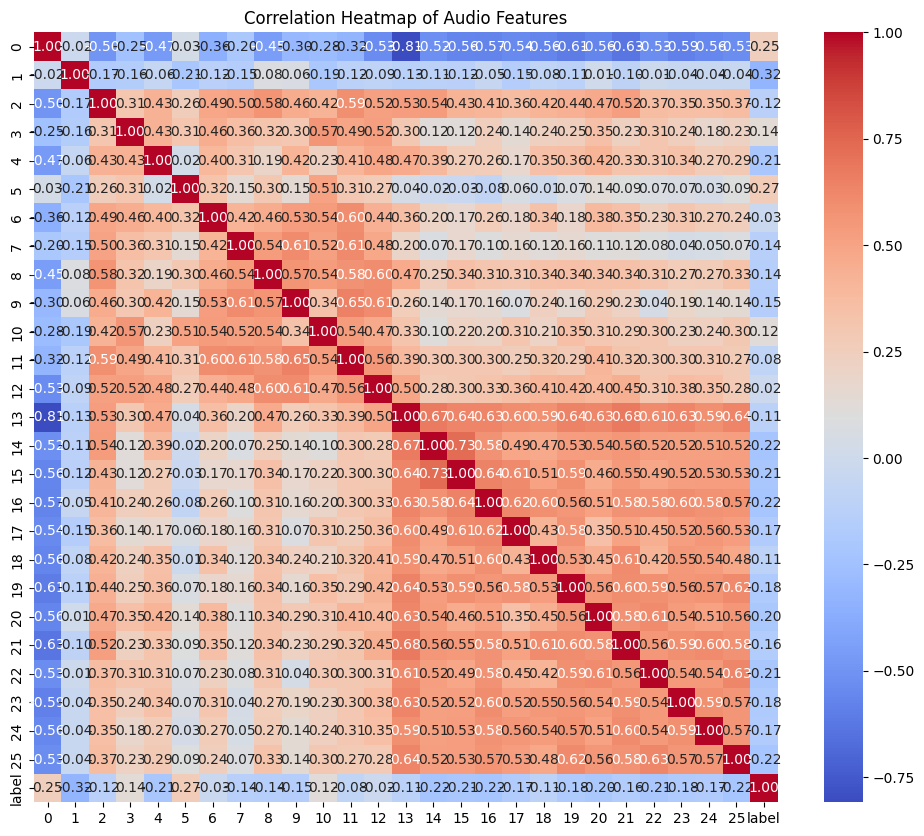

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(df_features.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Audio Features")
plt.show()


In [21]:
#df_features.drop(columns={14}, inplace=True)
#df_features# 14 was highly correlated

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df_features.drop(columns=['label'])
y = df_features['label']
# Split before scaling to avoid data leakage
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val_split)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train_split)
y_pred = clf.predict(X_val_scaled)
print(classification_report(y_val_split, y_pred))


              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2159
           1       1.00      0.87      0.93       478

    accuracy                           0.98      2637
   macro avg       0.98      0.93      0.96      2637
weighted avg       0.98      0.98      0.98      2637



In [23]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Assuming df_features is already created with 26 features and a 'label' column
# df_features shape: (number_of_samples, 27) -- 26 features + label

# Separate features and labels
X = df_features.drop(columns=['label'])
y = df_features['label']

# Perform oversampling to balance the classes
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
print("Resampled distribution:", Counter(y_resampled))

# Split the oversampled dataset into training and validation sets
X_train_res, X_val_res, y_train_res, y_val_res = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# Scale the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_val_scaled = scaler.transform(X_val_res)

# Train a Random Forest classifier on the oversampled, scaled training data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train_res)

# Predict on the validation set
y_pred = clf.predict(X_val_scaled)

# Evaluate the classifier
print("Classification Report for Random Forest (with oversampling):")
print(classification_report(y_val_res, y_pred))


Resampled distribution: Counter({0: 10660, 1: 10660})
Classification Report for Random Forest (with oversampling):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2154
           1       1.00      1.00      1.00      2110

    accuracy                           1.00      4264
   macro avg       1.00      1.00      1.00      4264
weighted avg       1.00      1.00      1.00      4264



In [24]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Step 1: Initialize the base XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Step 2: Set up the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Step 3: Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1_weighted',  # You could also use 'accuracy' or 'f1_macro'
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Step 4: Fit the model on oversampled & scaled training data
grid_search.fit(X_train_scaled, y_train_res)

# Step 5: Print best parameters
print("Best Hyperparameters from GridSearchCV:")
print(grid_search.best_params_)

# Step 6: Evaluate the best model on the scaled validation set
best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(X_val_scaled)

print("Classification Report for XGBoost:")
print(classification_report(y_val_res, y_pred_xgb))


Fitting 3 folds for each of 72 candidates, totalling 216 fits


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [14:15:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters from GridSearchCV:
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2154
           1       1.00      1.00      1.00      2110

    accuracy                           1.00      4264
   macro avg       1.00      1.00      1.00      4264
weighted avg       1.00      1.00      1.00      4264



In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Assume X_resampled and y_resampled are produced by RandomOverSampler as in your code:
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Convert oversampled arrays into a DataFrame, if desired:
df_resampled = pd.DataFrame(X_resampled)
df_resampled['label'] = y_resampled

# Split the oversampled data into training and validation sets
X_over = df_resampled.drop(columns=['label'])
y_over = df_resampled['label']
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_over, y_over, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val_split)

# Set up XGBoost with GridSearchCV (as before)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearch on the oversampled, scaled training set
grid_search.fit(X_train_scaled, y_train_res)
print("Best Hyperparameters from GridSearchCV:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(X_val_scaled)
print("Classification Report for XGBoost:")
print(classification_report(y_val_res, y_pred_xgb))


Fitting 3 folds for each of 72 candidates, totalling 216 fits


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [14:17:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters from GridSearchCV:
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2154
           1       1.00      1.00      1.00      2110

    accuracy                           1.00      4264
   macro avg       1.00      1.00      1.00      4264
weighted avg       1.00      1.00      1.00      4264



## 💾 Export Models for Streamlit App

Run the cell below to save your trained models so they can be used in the Streamlit web application!

In [ ]:
del app.htmlimport pickle
import os
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

def save_model_for_streamlit(model, scaler, model_name, X_val, y_val):
    """
    Save model, scaler, and metadata for Streamlit app
    """
    # Calculate performance metrics
    y_pred = model.predict(X_val)
    
    metrics = {
        'accuracy': float(accuracy_score(y_val, y_pred)),
        'precision': float(precision_score(y_val, y_pred, average='weighted')),
        'recall': float(recall_score(y_val, y_pred, average='weighted')),
        'f1_score': float(f1_score(y_val, y_pred, average='weighted')),
        'training_samples': len(X_val)
    }
    
    # Save model
    model_path = f'models/{model_name}_model.pkl'
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"✅ Model saved: {model_path}")
    
    # Save scaler
    scaler_path = f'models/{model_name}_scaler.pkl'
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"✅ Scaler saved: {scaler_path}")
    
    # Save metadata
    metadata_path = f'models/{model_name}_metadata.json'
    with open(metadata_path, 'w') as f:
        json.dump(metrics, f, indent=4)
    print(f"✅ Metadata saved: {metadata_path}")
    print(f"\n📊 Model Performance:")
    for metric, value in metrics.items():
        print(f"   {metric}: {value:.4f}")
    print()

# Export Random Forest model
print("="*60)
print("Exporting Random Forest Model")
print("="*60)
save_model_for_streamlit(clf, scaler, 'random_forest', X_val_scaled, y_val_res)

# Export XGBoost model
print("="*60)
print("Exporting XGBoost Model")
print("="*60)
save_model_for_streamlit(best_model, scaler, 'xgboost', X_val_scaled, y_val_res)

print("\n" + "="*60)
print("✅ All models exported successfully!")
print("="*60)
print("\n🚀 You can now run the Streamlit app:")
print("   streamlit run app_streamlit.py")
print("\n💡 The app will automatically load your trained models!")

Exporting Random Forest Model
✅ Model saved: models/random_forest_model.pkl
✅ Scaler saved: models/random_forest_scaler.pkl
✅ Metadata saved: models/random_forest_metadata.json

📊 Model Performance:
   accuracy: 0.9981
   precision: 0.9981
   recall: 0.9981
   f1_score: 0.9981
   training_samples: 4264.0000

Exporting XGBoost Model
✅ Model saved: models/xgboost_model.pkl
✅ Scaler saved: models/xgboost_scaler.pkl
✅ Metadata saved: models/xgboost_metadata.json

📊 Model Performance:
   accuracy: 0.9988
   precision: 0.9988
   recall: 0.9988
   f1_score: 0.9988
   training_samples: 4264.0000


✅ All models exported successfully!

🚀 You can now run the Streamlit app:
   streamlit run app_streamlit.py

💡 The app will automatically load your trained models!
✅ Model saved: models/random_forest_model.pkl
✅ Scaler saved: models/random_forest_scaler.pkl
✅ Metadata saved: models/random_forest_metadata.json

📊 Model Performance:
   accuracy: 0.9981
   precision: 0.9981
   recall: 0.9981
   f1_score